In [21]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import os, argparse
import cv2, spacy, numpy as np
from keras.models import model_from_json
from keras.optimizers import SGD
from keras.preprocessing import image
from sklearn.externals import joblib
import sklearn
import matplotlib.pyplot as plt
from keras import backend as K
from keras.utils.vis_utils import plot_model
K.set_image_data_format('channels_first')
#K.set_image_dim_ordering('th')

In [22]:
# 除了CNN_weights，其它所有都在目录中提供，CNN_weights在google drive中下载
VQA_model_file_name      = 'models/VQA/VQA_MODEL.json'
VQA_weights_file_name   = 'models/VQA/VQA_MODEL_WEIGHTS.hdf5'
label_encoder_file_name  = 'models/VQA/FULL_labelencoder_trainval.pkl'
CNN_weights_file_name   = 'models/CNN/vgg16_weights.h5'

In [23]:
def get_image_model(CNN_weights_file_name):
    # 接收CNN权重文件
    # 返回带有该权重的VGG模型更新
    # 需要使用models/CNN中的VGG.py文件
    from models.CNN.VGG import VGG_16
    image_model = VGG_16(CNN_weights_file_name)
    image_model.layers.pop()
    image_model.layers.pop()
    # 不包含最后两层的标准VGG文件
    sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
    image_model.compile(optimizer=sgd, loss='categorical_crossentropy')
    return image_model

In [4]:
model_vgg = get_image_model(CNN_weights_file_name)
plot_model(model_vgg, to_file='model_vgg.png')

In [24]:
def get_image_features(image_file_name):
    # 使用给定的图像文件运行VGG 16模型
    # 将权重作为(1,4096)维向量返回
    image_features = np.zeros((1, 4096))

    # 由于VGG被训练成224x224的图像，每一个新图形都需要经过同样的转换
    im = cv2.resize(cv2.imread(image_file_name), (224, 224))
    # 把图像转为RGBA格式
    im = im.transpose((2,0,1)) 

    
    # 这个轴的维度是必须的，因为VGG是在1, 3, 224, 224维度上训练的
    # 尽管我们只使用一张图片，但我们必须保持维度的一致
    im = np.expand_dims(im, axis=0) 

    image_features[0,:] = model_vgg.predict(im)[0]
    return image_features

In [25]:
def get_question_features(question):
    # 对于一个给定的问题，一个unicode字符串，返回使用Glove Vector计算的时间序列向量
    word_embeddings = spacy.load('en_vectors_web_lg')
    tokens = word_embeddings(question)
    question_tensor = np.zeros((1, 30, 300))
    for j in range(len(tokens)):
        question_tensor[0,j,:] = tokens[j].vector
    return question_tensor

In [26]:
word_embeddings = spacy.load('en_core_web_sm', vectors='en_glove_cc_300_1m_vectors')

In [27]:
obama = word_embeddings(u"obama")
putin = word_embeddings(u"putin")
banana = word_embeddings(u"banana")
monkey = word_embeddings(u"monkey")

In [28]:
obama.similarity(putin)

0.6642846299508524

In [29]:
obama.similarity(banana)

0.5820274780340965

In [30]:
banana.similarity(monkey)

0.5464804422621221

In [31]:
def get_VQA_model(VQA_model_file_name, VQA_weights_file_name):
    # 给定VQA模型和它的权重，编译并返回更新后的模型
    vqa_model = model_from_json(open(VQA_model_file_name).read())
    vqa_model.load_weights(VQA_weights_file_name)
    vqa_model.compile(loss='categorical_crossentropy', optimizer='rmsprop')
    return vqa_model

In [32]:
model_vqa = get_VQA_model(VQA_model_file_name, VQA_weights_file_name)
plot_model(model_vqa, to_file='model_vqa.png')

In [33]:
image_file_name = 'test.jpg'
question = u"Who are you?"

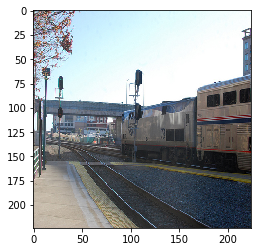

In [34]:
# 获得图像特征
image_features = get_image_features(image_file_name)
img = image.load_img(image_file_name, target_size=(224,224))

plt.imshow(img)

In [35]:
# 获取问题特征
question_features = get_question_features(question)

In [36]:
y_output = model_vqa.predict([question_features, image_features])
warnings.filterwarnings("ignore", category=DeprecationWarning)
labelencoder = joblib.load(label_encoder_file_name)
for label in reversed(np.argsort(y_output)[0,-5:]):
    print(str(round(y_output[0,label]*100,2)).zfill(5), "% ", labelencoder.inverse_transform(label.reshape(-1,1)))

34.57 %  ['no one']
29.05 %  ['people']
13.72 %  ['man']
006.2 %  ['photographer']
05.66 %  ['skier']
